In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import scipy as scipy
from tqdm.auto import tqdm
import requests
from urllib.parse import urlencode
%matplotlib inline

In [107]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize': (16, 5)})

### Задание 1
### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

#### Считываем данные и проводим EDA

In [108]:
# cчитываем данные о времени регистрации
df_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [109]:
# оцениваем объем датафрейма:
df_reg.shape

(1000000, 2)

In [110]:
# проверяем на наличие пропусков:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [111]:
# проверяем на наличие дубликатов:
df_reg.duplicated().value_counts()

False    1000000
dtype: int64

#### Дубликаты и пропуски отсутствуют

In [112]:
# смотрим тип данных:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [113]:
# переводим поле reg_ts в формат даты: 
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s').dt.normalize()

In [114]:
# выводим информацию, проверяем форматы:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [115]:
df_reg.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [116]:
# cчитываем данные о времени захода пользователей в игру
df_enter = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
df_enter.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [117]:
# оцениваем объем датафрейма:
df_enter.shape

(9601013, 2)

In [118]:
# проверяем на наличие пропусков:
df_enter.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [119]:
# проверяем на наличие дубликатов:
df_enter.duplicated().value_counts()

False    9601013
dtype: int64

#### Дубликаты и пропуски отсутствуют

In [120]:
# смотрим тип данных:
df_enter.dtypes

auth_ts    int64
uid        int64
dtype: object

In [121]:
# переводим поле reg_ts в формат даты: 
df_enter['auth_ts'] = pd.to_datetime(df_enter['auth_ts'], unit='s').dt.normalize()

In [122]:
# выводим информацию, проверяем форматы:
df_enter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


In [123]:
df_enter.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [124]:
def ret(df_reg, df_enter, start_reg, end_reg, days):
    """ Функция считает retention игроков (по дням от даты регистрации игрока)
    
    На вход принимает: 
    df_reg - данные о времени регистрации
    df_enter - данные о времени захода пользователей в игру
    end_reg - дата окончания регистрации
    days - количество дней за которые необходимо посчитать retention"""
    
    df_reg = df_reg[(df_reg.reg_ts >= start_reg) & (df_reg.reg_ts <= end_reg)]
    df = df_reg.merge(df_enter, on='uid', how='left')
    df['diff_time'] = (df.auth_ts - df.reg_ts).dt.days
    df_1 = df.query('diff_time <= @days').groupby(['reg_ts', 'diff_time'], as_index=False) \
        .agg({'uid': 'count'}) \
        .pivot(index='reg_ts', columns='diff_time', values='uid')
    df_retention = df_1.div(df_1[0], axis=0)
    df_retention = df_retention.drop(columns=df_retention.columns[0], axis=1)
    
    ax = sns.heatmap(df_retention, annot=True, vmin=0.0, vmax=0.1, fmt='.2%', cmap='Greens')
    ax.set_yticklabels(df_retention.index.strftime('%Y-%m-%d'))
    ax.set(xlabel='Days', ylabel='Reg_date', title='Retention')
    plt.show()

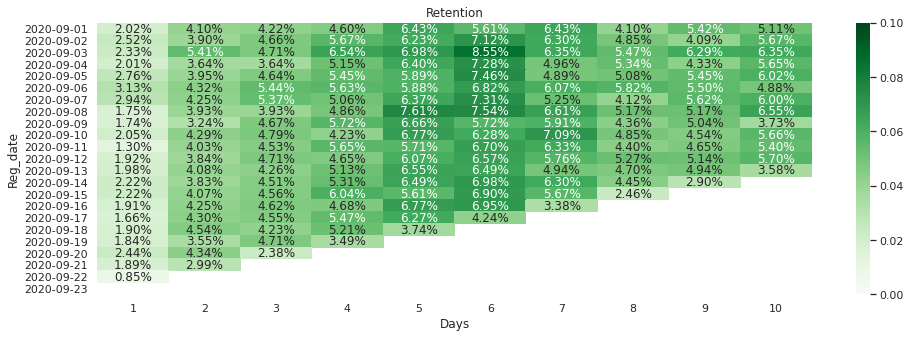

In [125]:
ret(df_reg, df_enter, '2020-09-01', '2020-09-23', 10)

#### Функция ret() считает retention игроков (по дням от даты регистрации игрока), на вход принимает: 
* df_reg - данные о времени регистрации                                                                                         

* df_enter - данные о времени захода пользователей в игру                                                                       

* start_reg - дата начала регистрации                                                                                           

* end_reg - дата окончания регистрации                                                                                           

* days - количество дней за которые необходимо посчитать retention     

### Задание 2
### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

#### Считываем данные и проводим EDA

In [126]:
# ссылка на яндекс диск:
url = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [127]:
# создание функции считывающей файл с яндекс диска:
def get_file(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [128]:
df = pd.read_csv(get_file(url), sep=';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [129]:
df.shape

(404770, 3)

In [130]:
# проверяем на наличие пропусков:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [131]:
# проверяем на наличие дубликатов:
df.duplicated().value_counts()

False    404770
dtype: int64

#### Дубликаты и пропуски отсутствуют

In [132]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [133]:
# Смотрим кол-во пользователей в группах:
df_count = df.groupby('testgroup', as_index=False).agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'count_users'})

In [134]:
df_count

,testgroup,count_users
0,a,202103
1,b,202667


In [135]:
# смотрим средний доход по группам: средний доход в тестовой группе выше
df.groupby('testgroup', as_index=False).agg({'revenue': 'mean'})

,testgroup,revenue
0,a,25.413720
1,b,26.751287


#### Смотрим описательную статистику по группам:

In [136]:
df[(df.testgroup == 'a')].revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [137]:
df[df.testgroup == 'b'].revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

#### Кол-во пользователей в тестовой группе больше чем в контрольной, максильное значение выручки в контрольной группе значительно превышает значение в тестовой группе

#### Для выбора лучшего акционного предложения мы будем анализировать следующие метрики: 
* *ARPU* - средняя выручка с пользователя, показывает, сколько игрок в среднем тратит на продукт за определенный период времени, поможет спрогнозировать прибыль, принять решения об эффективности акции, маркетинга
* *ARPPU* - средняя выручка с платящего пользователя, показывает среднюю прибыль от одного платящего игрока за определенный период времени, поможет измерить ценность продукта компании и спрогнозировать доход.
* *CR* - конверсия в покупку, соотношение тех игроков кто совершил покупку к общему количеству игроков, поможет принять решения об эффективности акции

### 1. Оценим данные по пользователям и расчитаем ARPU
#### Для начала посчитаем суммарную выручку по группам:

In [138]:
df_revenue = df.groupby('testgroup', as_index=False).agg({'revenue': 'sum'}) \
    .rename(columns={'revenue':'sum_revenue'})

In [139]:
df_revenue

,testgroup,sum_revenue
0,a,5136189
1,b,5421603


In [140]:
# считаем разницу выручки между группами:
abs((df_revenue.iloc[0, 1] - df_revenue.iloc[1, 1]) / df_revenue.iloc[1, 1] * 100)

5.264383983851271

#### Выручка в тестовой группе превышает на 5,26% выручку в контрольной

In [141]:
df_ARPU = df_count.merge(df_revenue, on='testgroup')

In [142]:
df_ARPU

,testgroup,count_users,sum_revenue
0,a,202103,5136189
1,b,202667,5421603


In [143]:
# Считаем ARPU: выручка по группе / кол-во пользователей в группе
df_ARPU['ARPU'] = round(df_ARPU.sum_revenue / df_ARPU.count_users, 2)

In [144]:
df_ARPU

,testgroup,count_users,sum_revenue,ARPU
0,a,202103,5136189,25.41
1,b,202667,5421603,26.75


In [145]:
df_ARPU_diff = abs((df_ARPU.iloc[0, 3] - df_ARPU.iloc[1, 3]) / df_ARPU.iloc[1, 3] * 100)

In [146]:
df_ARPU_diff

5.009345794392523

#### ARPU тестовой группы действительно превышает ARPU в контрольной на 5%

#### Для определения стат значимости проведем статистические тесты:

#### Проверка на гомогенность дисперсий с помощью теста Левена

In [147]:
scipy.stats.levene(df[df.testgroup == 'a'].revenue, df[df.testgroup == 'b'].revenue)
# pvalue > 0.05 значит подтверждаем нулевую гипотезу о однородности дисперсий

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

#### pvalue > 0.05 - значит подтверждаем нулевую гипотезу о однородности дисперсий

#### Проверка на нормальность распределений

In [148]:
scipy.stats.normaltest(df[df.testgroup == 'a'].revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [149]:
scipy.stats.normaltest(df[df.testgroup == 'b'].revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

#### В обеих группах pvalue < 0.05 - данные распределены не нормально

#### Построим графики, оценим распределение визуально

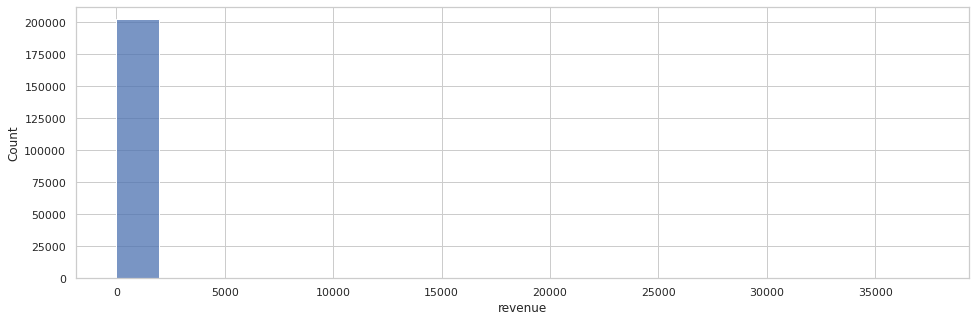

In [150]:
sns.histplot(df[df.testgroup == 'a'].revenue)

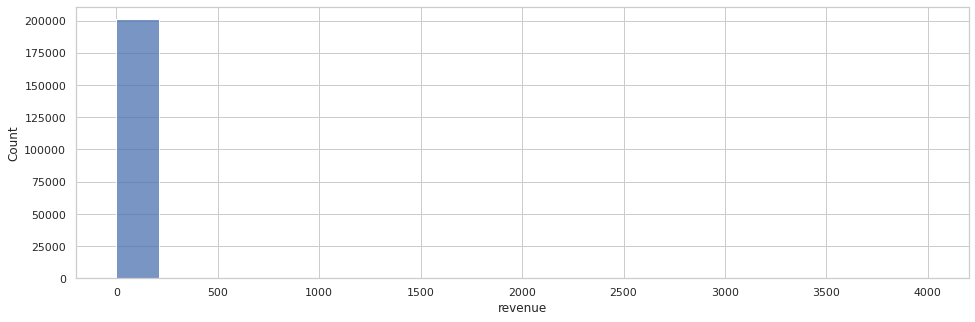

In [151]:
sns.histplot(df[df.testgroup == 'b'].revenue)

#### Как видим из графиков и по результатам тестов данные действительно распределены не нормально

#### Обозначим гипотезы:
* Нулева гипотеза H0 - Стат значимых различий по ARPU между контрольной и тестовой группой - нет
* Альтернативная гипотеза Н1 - Стат значимые различия по ARPU между контрольной и тестовой группе - есть

#### Чтобы применять ttest, Т-критерий Стьюдента нужно иметь гомогенности дисперсий и нормальное распредеоление в выборках, однако ttest допустимо использовать в случаях больший выборок

In [152]:
# проводим ttest:
ttest_ind(df[df.testgroup == 'a'].revenue, df[df.testgroup == 'b'].revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

#### pvalue > 0,05 - подтверждаем нулевую гипотезу - стат значимых различий нет

#### Проведем непараметрический аналог – U-критерий Манна-Уитни, который не чувствителем к выбросам

In [153]:
mannwhitneyu(df[df.testgroup == 'a'].revenue,
             df[df.testgroup == 'b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

#### Тест Манна-Уитни показал значие pvalue > 0,05 что также подтверждает нулевую гипотезу - стат значимых различий нет

### По результатам проведенных статистических тестов (Т-критерий Стьюдента и тест Манна-Уитни) можно сделать вывод, о подтверждении нулевой гипотезы - стат значимых различий по ARPU между контрольной и тестовой группой нет

### 2. Оценим данные по платящим пользователям и расчитаем ARPPU

#### Для начала расчитаем количество платящим пользователей контрольной и тестовой группах

In [154]:
df_pay_users = df.query('revenue != 0').groupby('testgroup', as_index=False).agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'count_pay_users'})

In [155]:
df_pay_users

,testgroup,count_pay_users
0,a,1928
1,b,1805


#### Видим, что в контрольной группе на 123 платящего пользователя больше чем в тестовой

In [156]:
# средние значения дохода по группам среди платящих пользователей:
df.query('revenue != 0').groupby('testgroup', as_index=False).agg({'revenue': 'mean'}) 

,testgroup,revenue
0,a,2663.998444
1,b,3003.658172


#### Посмотрим на графики распределений значений дохода в группах среди платящих пользователей:

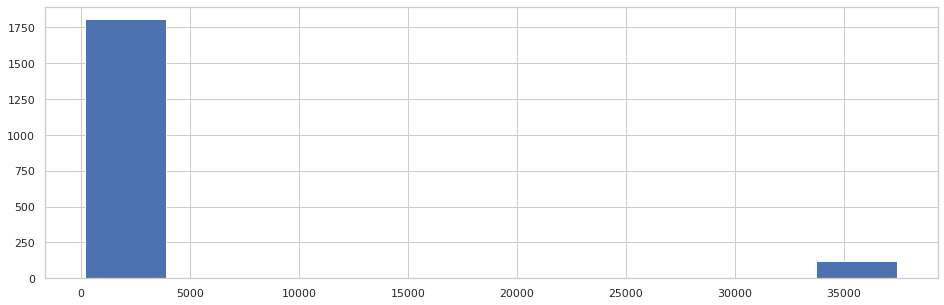

In [157]:
df[(df.testgroup == 'a') & (df.revenue != 0)].revenue.hist()

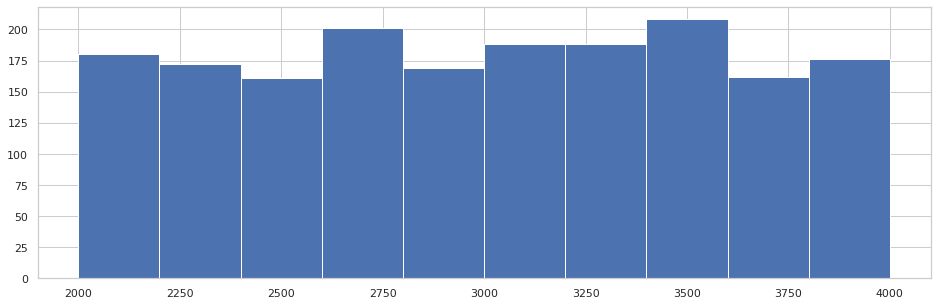

In [158]:
df[(df.testgroup == 'b') & (df.revenue != 0)].revenue.hist()

#### Смотрим описательную статистику среди платящих пользователей:

In [159]:
df[(df.testgroup == 'a') & (df.revenue != 0)].revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [160]:
df[(df.testgroup == 'b') & (df.revenue != 0)].revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

#### Видим, что в контрольной группе на 123 платящего пользователя больше чем в тестовой, среднее значение выручки в тестовой группе выше, при этом максимальное значение выручки в контрольной группе значительно превышает значение в тестовой группе

#### Рассмотрим значения в группах среди платящих пользователей подробнее

In [161]:
df.query("testgroup == 'a' and revenue != 0") \
    .sort_values('revenue', ascending = False) \

,user_id,revenue,testgroup
101861,101862,37433,a
196601,196602,37407,a
65077,65078,37394,a
21585,21586,37385,a
142804,142805,37379,a
...,...,...,...
119128,119129,200,a
246509,246510,200,a
230062,230063,200,a
340912,340913,200,a


In [169]:
df.query("testgroup == 'a' and revenue != 0") \
    .sort_values('revenue', ascending=False) \
    .query('revenue > 37000')

,user_id,revenue,testgroup
101861,101862,37433,a
196601,196602,37407,a
65077,65078,37394,a
21585,21586,37385,a
142804,142805,37379,a
...,...,...,...
254113,254114,37294,a
81477,81478,37294,a
34534,34535,37294,a
235858,235859,37294,a


#### В контрольной группе доход у 123 платящих пользователей значительно превышает доход у остальных платящих пользователей, максимальное значение дохода - 37433

In [170]:
df.query("testgroup == 'b'and revenue != 0") \
    .sort_values('revenue', ascending=False).head(20)

,user_id,revenue,testgroup
149618,149619,4000,b
34357,34358,4000,b
36472,36473,3999,b
185454,185455,3999,b
85614,85615,3995,b
47825,47826,3995,b
201302,201303,3995,b
303824,303825,3993,b
372303,372304,3993,b
30244,30245,3992,b


#### В тестовой группе доходы с платящих пользователей распределены равномерно, максимальное значение - 4000

In [171]:
# посмотрим на медианные значения дохода по группам
df.query('revenue != 0').groupby('testgroup', as_index=False).agg({'revenue': 'median'})

,testgroup,revenue
0,a,311
1,b,3022


#### Видим, что медиана в тестовой группе значительно превосходит (на 89,7%) медиану в контрольной группе

#### Приступим к расчету ARPPU в группах

In [172]:
df_ARPPU = df_pay_users.merge(df_revenue, on='testgroup')

In [173]:
df_ARPPU

,testgroup,count_pay_users,sum_revenue
0,a,1928,5136189
1,b,1805,5421603


In [175]:
# Считаем ARPU - выручка по группе / кол-во платящих пользователей в группе
df_ARPPU['ARPPU'] = round(df_ARPPU.sum_revenue / df_ARPPU.count_pay_users, 2)

In [176]:
df_ARPPU

,testgroup,count_pay_users,sum_revenue,ARPPU
0,a,1928,5136189,2664.00
1,b,1805,5421603,3003.66


In [177]:
df_ARPPU_diff = abs((df_ARPPU.iloc[0, 3] - df_ARPPU.iloc[1, 3]) / df_ARPPU.iloc[1, 3] * 100)

In [178]:
df_ARPPU_diff

11.308203991130817

#### Значение ARPPU в тестовой группе на 11,3% превышает значения в контрольной группе 
#### Для определения стат значимости проведем статистические тесты:

#### Проверка на гомогенность дисперсий с помощью теста Левена

In [179]:
scipy.stats.levene(df[(df.testgroup == 'a') & (df.revenue != 0)].revenue,
                   df[(df.testgroup == 'b') & (df.revenue != 0)].revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

#### pvalue < 0.05 значит НЕ подтверждаем нулевую гипотезу о однородности дисперсий

#### Проверка на нормальность распределения среди платящих пользователей

In [181]:
scipy.stats.normaltest(df[(df.testgroup == 'a') & (df.revenue != 0)].revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [182]:
scipy.stats.normaltest(df[(df.testgroup == 'b') & (df.revenue != 0)].revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

#### В обоих группах pvalue < 0.05  НЕ подтверждаем нулевую гипотезу, данные распределены не нормально

#### Построим графики, оценим распределение визуально

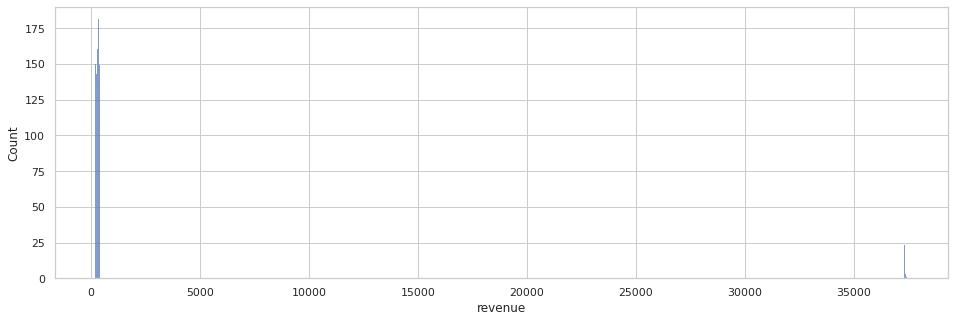

In [183]:
sns.histplot(df[(df.testgroup == 'a') & (df.revenue != 0)].revenue)

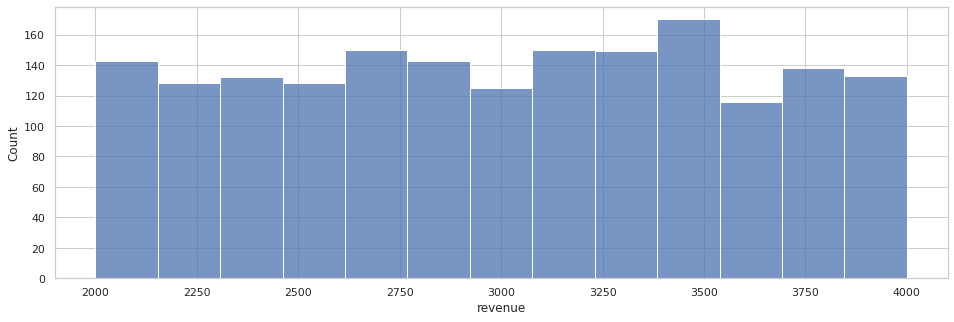

In [184]:
sns.histplot(df[(df.testgroup == 'b') & (df.revenue != 0)].revenue)

#### Как видим из графиков и по результатам тестов данные действительно распределены не нормально

#### Обозначим гипотезы:
* Нулева гипотеза H0 - Стат значимых различий по ARPPU между контрольной и тестовой группой - нет
* Альтернативная гипотеза Н1 - Стат значимые различия по ARPPU между контрольной и тестовой группе - есть

#### Т.к дисперсии в выборках не однородны и данные распределены не нормально применять ttest, Т-критерий Стьюдента не будем

#### Проводем Бутстрап для проверки стат значимости:

In [186]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,  # чтобы сохранить дисперсию, берем такой же размер выборки
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

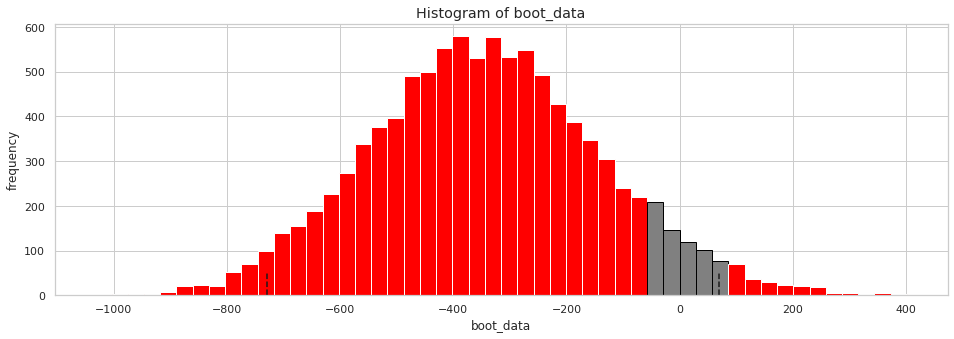

In [187]:
bootstrap_3 = get_bootstrap(
    df[(df.testgroup == 'a') & (df.revenue != 0)].revenue,
    df[(df.testgroup == 'b') & (df.revenue != 0)].revenue,
    boot_it=10000, 
    statistic=np.mean,
    bootstrap_conf_level=0.95
)

In [188]:
bootstrap_3['p_value']

0.09378014690235799

In [189]:
bootstrap_3['quants']

,0
0.025,-729.624455
0.975,69.682184


#### При сравнении групп методом Бутстрап pvalue > 0.05, 95-й доверительный интерал интервал включает 0, это значит, что у нас нет оснований отклонить нулевую гипотезу, стат значимых различий нет

### По результатам проведенного статистического теста (Бутстрап) можно сделать вывод, о подтверждении нулевой гипотезы - стат значимых различий по ARPPU между контрольной и тестовой группой нет

### 3. Оценим данные и расчитаем конверсию (CR) в покупку

#### Объединяем таблицы с ARPU, ARPPU и считаем конверсию (CR)

In [191]:
df_1 = df_ARPU.merge(df_ARPPU, on=['testgroup', 'sum_revenue'])

In [193]:
df_1 = df_1[['testgroup', 'count_users', 'count_pay_users', 'sum_revenue', 'ARPU', 'ARPPU']]

In [194]:
df_1

,testgroup,count_users,count_pay_users,sum_revenue,ARPU,ARPPU
0,a,202103,1928,5136189,25.41,2664.00
1,b,202667,1805,5421603,26.75,3003.66


In [195]:
# считаем конверсию в покупку: отношение количества платящих пользователей к количеству пользователей
df_1['СR'] = df_1.count_pay_users / df_1.count_users

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [197]:
df_1

,testgroup,count_users,count_pay_users,sum_revenue,ARPU,ARPPU,СR
0,a,202103,1928,5136189,25.41,2664.00,0.009540
1,b,202667,1805,5421603,26.75,3003.66,0.008906


#### Обозначим гипотезы:
* Нулева гипотеза H0 - Стат значимых различий по CR между контрольной и тестовой группой - нет
* Альтернативная гипотеза Н1 - Стат значимые различия по CR между контрольной и тестовой группе - есть

#### Для оценки стат значимости будем использовать критерий Хи-квадрат для двух случайных величин

In [206]:
df_cr = df_1[['testgroup','count_pay_users', 'count_users']]

In [207]:
df_cr

,testgroup,count_pay_users,count_users
0,a,1928,202103
1,b,1805,202667


In [210]:
df_cr_1 = df_cr.pivot_table(columns='testgroup', values=['count_pay_users', 'count_users'])

In [211]:
df_cr_1

testgroup,a,b
count_pay_users,1928,1805
count_users,202103,202667


In [215]:
stat, p, dof, expected = ss.chi2_contingency(df_cr_1)
p

0.03824373651044171

#### Критерий Хи-квадрат показал p-value < 0,05, значит у нас есть основания отклонить нулевую гипотезу - стат значимые различия по CR между контрольной и тестовой группе есть

### *Вывод*

### По результатам проведения A/B тестирования двух групп пользователей с различными наборами акционных предложений, средний доход с пользователя (ARPU) в тестовой группе выше чем APRU в контрольной на 5%, при этом статистические тесты показали, что данное различие не является стат значимым. Аналогично дело обстоит с показателем ARPPU: где средний доход с платящего пользователя в тестовой группе также выше чем ARPPU в контрольной группе, но уже на 11% и статистические тесты показали, что данное различие не является стат значимым.

### При этом конверсия в покупку (CR) в контрольной группе выше чем конверсия в тестовой,  и статистические тесты показали, что данное различие является статистически значимым. Это означает что при использовании акционного предложения в тестововой группе люди не так активно приобретают товар, идет потеря дохода.

### На основе вышеизложенного можно сделать вывод, что набор акционных предложений в контрольной группе более привлекательный, так как может обеспечить более высокий, доход. Однако, учитывая сильный разброс данных, в частности в контрольной группе, относительно величины оплаты, можно предположить, что сплитование для проведения теста выполнено неккоретно, требуется корректировка и повтоное проведение A/B эксперемента. 

### Задание 3
### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### С помощью следующих метрик можно оценить результаты последнего прошедшего события:

***Метрики роста:***
1. Event users (EU) - количество уникальных игроков, принимавших участие в тематическом событии (далее event).
Можно оценить как много людей принимает участие в event.
2. Event rate (ER) = EU / MAU - доля пользователей принимавших участие в event относительно количества уникальных пользователей заходивших в игру в этом месяце.
Можно оценить на сколько хорошо привлекаются игроки в принятии участиия в event, возможно нужны дополнительные ресурсы на привлечение игроков (оповещения, реклама и т.д)

***Метрики продукта:***
3. Success event rate (SER) = Succes event users / EU - доля игроков успешно прошедших event относительно всех игроков принимавших в нем участие.
Можно оценить на сколько просто/сложно выполняется прохождение event, возможно нужно корректировать уровень сложности.
4. Сonversion (конверсия) = EU (n+1) / EU (n) - доля игроков принимавших участие в event, относительно предыдущего event.
Можно оценить на сколько хорошо происходит наращиваени количества игроков от event к event, возможно нужны дополнительные ресурсы на привлечение игроков
5. Retention = EU из (n) сохранившиеся в (n+1) / EU из (n) - удержание, доля вернувшихся игроков относительно предыдущего event
Можно оценить на сколько хорошо происходит удержание, активных игроков, возможно нужны дополнительные бонусы (какие-нибудь грабли либо лопаты), в качестве мотивации.
6. Average event time = total time per event / EU - сколько времени в среднем один игрок тратит на event.
Можно оценить на сколько игрокам нравится/ не нравится проводить время в event, а также при соотнесении с показателем успешности выполнения, можно оценить уровень сложность

***Финансовые метрики:***
7. ARPU/ARPPU - ср.доход полученный с одного участника event
8. Total Revenue - общий доход полученный с проведения event

### Если усложнить механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад к представленным выше метракам можно добавить 
9. Churn Rate = EU из (n) отвалившиеся в (n+1) / EU из (n) - отток пользователей, доля отвалившихся игроков относительно предыдущего event, 
это нужно отслеживать т.к откат на несколько уровней назад может негативно повлиять на настроение игроков. Если данный показатель будет сильно высоким,
можно рассмотреть возможность изменения концепции тематического события либо изменения сложности прохождения уровней

